In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert("RGB")
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape:
        size = shape
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)

In [4]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

In [5]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

## VGG Feature Extraction

In [6]:
def get_vgg():
    vgg = models.vgg16(pretrained=True).features.to(device).eval()
    for param in vgg.parameters():
        param.requires_grad_(False)
    return vgg

In [7]:
def vgg_features(x, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # for content
        '28': 'conv5_1'
    }
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


## ResNet Feature Exctraction

In [8]:
def get_resnet():
    resnet = models.resnet50(pretrained=True).to(device).eval()
    for param in resnet.parameters():
        param.requires_grad_(False)
    return resnet

In [9]:
def resnet_features(x, model):
    features = {}
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    features['conv1'] = x
    x = model.maxpool(x)
    x = model.layer1(x)
    features['layer1'] = x
    x = model.layer2(x)
    features['layer2'] = x
    x = model.layer3(x)
    features['layer3'] = x  # this layer is for content
    return features


## Style Functions

In [10]:
def style_transfer(model, extractor, content_img, style_img, content_layer, style_layers, steps=500, lr=0.005):
    target = content_img.clone().requires_grad_(True).to(device)
    optimizer = optim.Adam([target], lr=lr)

    content_features = extractor(content_img, model)
    style_features = extractor(style_img, model)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}

    content_weight = 1
    style_weight = 1e6

    for step in range(steps):
        target_features = extractor(target, model)
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer]) ** 2)

        style_loss = 0
        for layer in style_layers:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            d, h, w = target_feature.shape[1:]
            layer_loss = torch.mean((target_gram - style_gram) ** 2) / (d * h * w)
            style_loss += layer_loss

        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    return target, content_loss.item(), style_loss.item(), total_loss.item()


## Main Section

In [11]:
content_img = load_image("1.jpg")
style_img = load_image("2.jpg", shape=content_img.shape[2:])

In [12]:
results = {}

In [13]:
# VGG16
vgg = get_vgg()
start = time.time()
vgg_output, vgg_c, vgg_s, vgg_t = style_transfer(vgg, vgg_features, content_img, style_img, "conv4_2",
                                                 ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.5MB/s]


In [14]:
vgg_time = time.time() - start
results['VGG16'] = {
    'output': im_convert(vgg_output),
    'content_loss': vgg_c,
    'style_loss': vgg_s,
    'total_loss': vgg_t,
    'time': vgg_time
}

In [15]:
# ResNet50
resnet = get_resnet()
start = time.time()
res_output, res_c, res_s, res_t = style_transfer(resnet, resnet_features, content_img, style_img, "layer3",
                                                 ["conv1", "layer1", "layer2"])
res_time = time.time() - start
results['ResNet50'] = {
    'output': im_convert(res_output),
    'content_loss': res_c,
    'style_loss': res_s,
    'total_loss': res_t,
    'time': res_time
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


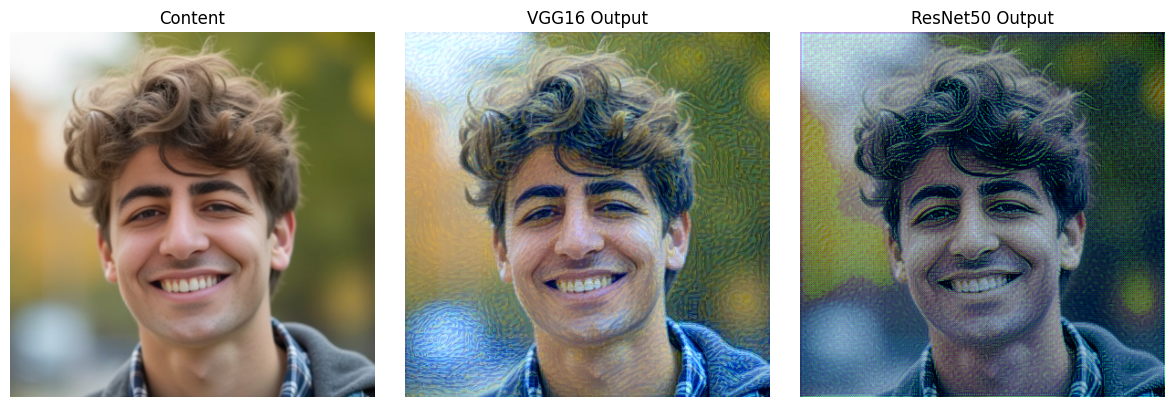

In [16]:
# Compare

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Content")
plt.imshow(im_convert(content_img))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("VGG16 Output")
plt.imshow(results['VGG16']['output'])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("ResNet50 Output")
plt.imshow(results['ResNet50']['output'])
plt.axis("off")
plt.tight_layout()
plt.savefig("visual_comparison.jpg")
plt.show()

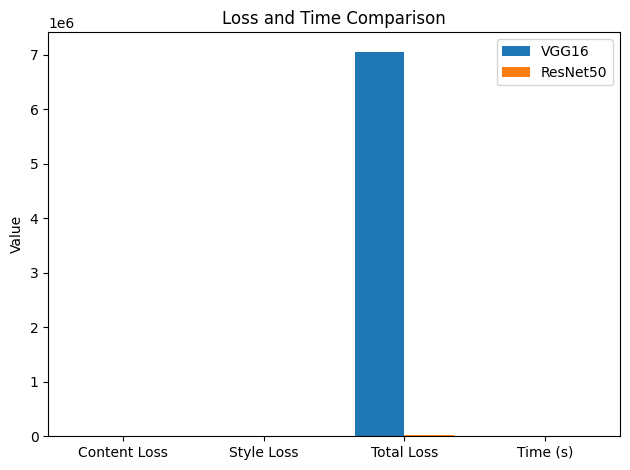

In [17]:
labels = ['Content Loss', 'Style Loss', 'Total Loss', 'Time (s)']
vgg_values = [results['VGG16']['content_loss'], results['VGG16']['style_loss'],
              results['VGG16']['total_loss'], results['VGG16']['time']]
res_values = [results['ResNet50']['content_loss'], results['ResNet50']['style_loss'],
              results['ResNet50']['total_loss'], results['ResNet50']['time']]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, vgg_values, width, label='VGG16')
ax.bar(x + width/2, res_values, width, label='ResNet50')
ax.set_ylabel('Value')
ax.set_title('Loss and Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.savefig("loss_comparison.jpg")
plt.show()
